In [3]:
#Import Library
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Reshape, Flatten
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")


# Read Data
data_path = '/content/drive/MyDrive/Dacon_Data/[DACON]Bit_Trader/data'
train_x_df = pd.read_csv(data_path  + "/train_x_df.csv")
train_y_df = pd.read_csv(data_path  + "/train_y_df.csv")
test_x_df = pd.read_csv(data_path  + "/test_x_df.csv")

# 시간 관계 상, train 데이터 상단의 300개 샘플를 구성하여 학습 및 추론
train_x_df = train_x_df[train_x_df.sample_id < 300]
train_y_df = train_y_df[train_y_df.sample_id < 300]
#train_x_df와 train_y_df time열을 기준으로 concatenate하기(일단 생략하고 x_train만 가지고 학습 진행할 것. 1380 + 120 = 1500개 데이터로 학습하나 1380개만 가지고 학습하나 모델의 성능에 큰 차이를 미치지는 않을 것으로 추측하기 때문)


# 입력 받은 2차원 데이터 프레임을 3차원 numpy array로 변경하는 함수
def df2d_to_array3d(df_2d):
    feature_size = df_2d.iloc[:,2:].shape[1]
    time_size = len(df_2d.time.value_counts())
    sample_size = len(df_2d.sample_id.value_counts())
    array_3d = df_2d.iloc[:,2:].values.reshape([sample_size, time_size, feature_size])
    return array_3d


# 2차원 DF LSTM으로 학습하기 위해 3차원으로 변환시키기
train_x_array = df2d_to_array3d(train_x_df)   #(300, 1380, 10)
train_y_array = df2d_to_array3d(train_y_df)   #(300, 120, 10)
test_x_array = df2d_to_array3d(test_x_df)     #(529, 1380, 10)


#모델 구성(op1: many-to-one model, op2: many-to-many model(output 모양 바꾸기, return_sequences = True, Window이동 단위 1에서 output 크기로 변경))
seq_len = 120
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences= True, input_shape = [seq_len, 1]))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))  #120개의 open값 입력되어 121번째 open값 '하나' 예측

model.compile(optimizer = 'adam', loss = 'mse')

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 120, 50)           10400     
_________________________________________________________________
lstm_5 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


In [4]:
# test_x_array에 대한 Auto_Regressive한 Prediction 및 valid_pred_array에 예측 결과 기록

# 1) test_pred_array{예측값 모아두는 3차원 배열(120*1 2차원 배열 529개)} 만들기
test_pred_array = np.zeros([len(test_x_array), 120, 1])

# 2) test_x_array로 시계열 Windows 만들기 -> 데이터셋 구성 -> 모델 학습 ||| 예측 -> test_pred_array에 기록 -> window_3d의 첫번째 값 삭제 -> test_pred_array와 window_3d 병합 -> model.predict()에 넣어 예측 -> ***

# test_x_array로 시계열 Windows 만들기
ep = 10
bs = 120
for idx in tqdm(range(test_x_array.shape[0])):  # 529번
    seq_len = 120
    sequence_length = seq_len + 1

    windows = []
    for index in range(1380 - sequence_length):
        windows.append(test_x_array[idx, :, 1][index: index + sequence_length])

    # x_test, y_test 데이터셋 구성
    windows = np.array(windows)  # 1329 * 121의 2차원 배열
    x_test = windows[:, :-1]
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
    y_test = windows[:, -1]

    # Fit
    model.fit(x_test, y_test, epochs= ep, batch_size= bs, verbose=0, shuffle = True)

    # test_x_array Windows 중 마지막 윈도우 추출해서 3차원 변환시켜 LSTM모델에 넣고 Predict
    window = windows[-1, :-1]
    window_3d = np.reshape(window, (1, window.shape[0], 1))
    for m in range(window.shape[0]):
        # model.predict()에 window_3d 넣어 예측
        pred = model.predict(window_3d)

        # 120분 중 처음 1분 예측값 test_pred_array에 기록
        test_pred_array[idx, m, :] = pred

        # window_3d의 첫번째 분 값은 삭제한 window_3d_2nd 구성
        window_3d_2nd = window_3d[0, 1:, :]  # 119개

        # pred_target(prediction할 때마다 나오는 각각의 예측값들) 1차원 -> 2차원으로 구성
        pred_target = test_pred_array[idx, m, :]
        pred_target = np.reshape(pred_target, (pred_target.shape[0], 1))

        # test_pred_array와 window_3d_2nd 병합하여 모델에 입력할 새로운 window_3d 재구성
        window_3d = np.concatenate((window_3d_2nd, pred_target), axis=0)
        window_3d = window_3d.T
        window_3d = np.reshape(window_3d, (window_3d.shape[0], window_3d.shape[1], 1))




  0%|          | 0/529 [00:00<?, ?it/s]

  0%|          | 1/529 [00:37<5:32:43, 37.81s/it]

  0%|          | 2/529 [01:13<5:26:29, 37.17s/it]

  1%|          | 3/529 [01:49<5:21:56, 36.72s/it]

  1%|          | 4/529 [02:25<5:19:11, 36.48s/it]

  1%|          | 5/529 [03:01<5:17:49, 36.39s/it]

  1%|          | 6/529 [03:37<5:16:01, 36.26s/it]

  1%|▏         | 7/529 [04:12<5:14:11, 36.11s/it]

  2%|▏         | 8/529 [04:48<5:12:57, 36.04s/it]

  2%|▏         | 9/529 [05:24<5:11:51, 35.98s/it]

  2%|▏         | 10/529 [06:00<5:10:31, 35.90s/it]

  2%|▏         | 11/529 [06:36<5:09:40, 35.87s/it]

  2%|▏         | 12/529 [07:12<5:09:49, 35.96s/it]

  2%|▏         | 13/529 [07:48<5:10:15, 36.08s/it]

  3%|▎         | 14/529 [08:24<5:08:36, 35.95s/it]

  3%|▎         | 15/529 [09:00<5:07:45, 35.92s/it]

  3%|▎         | 16/529 [09:35<5:06:25, 35.84s/it]

  3%|▎         | 17/529 [10:11<5:06:04, 35.87s/it]

  3%|▎         | 18/529 [10:47<5:05:14, 35.84s/it]

  4%|▎         | 19/529 [11:23

In [ ]:
# 손실값 시각화
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [5]:
#test_pred_array에 채워진 (sample_id x번째 자료에 대한)120분 예측값 확인
x = 528
print(test_pred_array.shape)

(529, 120, 1)


In [9]:
# 모델 저장 및 로드
model.save('./my_model.h5')
model = tf.keras.models.load_model('./my_model.h5')

In [10]:
# 매수 시점, 매수 비율 표 만들기
# 1) train_pred_array 3차원에서 2차원으로 바꾸기
pred_array_2d = np.zeros([test_pred_array.shape[0], 120])

for idx in tqdm(range(test_pred_array.shape[0])):
    pred_array_2d[idx, :] = test_pred_array[idx, :, 0]

# 2) 예측값을 재해석하여 submission 표를 작성하는 함수 정의
def array_to_submission(pred_array):
    submission = pd.DataFrame(np.zeros([pred_array.shape[0], 2], np.int64),
                              columns=['buy_quantity', 'sell_time'])
    submission = submission.reset_index()
    buy_price = []
    for idx, sell_time in enumerate(np.argmax(pred_array, axis=1)):
        buy_price.append(pred_array[idx, sell_time])
    buy_price = np.array(buy_price)
    submission.loc[:, 'buy_quantity'] = (buy_price > 1.15) * 1
    submission['sell_time'] = np.argmax(pred_array, axis=1)
    submission.columns = ['sample_id', 'buy_quantity', 'sell_time']
    return submission

final_submission = array_to_submission(pred_array_2d)

# 전체 300가지 sample에 대해 _가지 case에서 115% 이상 상승한다고 추론함.
final_submission.buy_quantity.value_counts()


# final_submission csv파일로 저장
final_submission.to_csv('./submission.csv', index = False)



# many-to-many 모델로 다시 돌려보기(input: 120, output: 10 정도?), optimizer을 rmsprop으로 설정해보기,
# 시가에 임의의 상수 곱해서 증폭된 값으로 입력해보기
# epoch 수 늘리고 batch_size 줄여서 다시 학습
# LSTM 레이어 조절해보기(2번째 레이어 Bidirectional로?)
# shuffle= True 효과 있을까?
# NLP 119페이지 Earlystopping 적용
# 모델의 마지막 레이어였던 reshape는 필요 없는 것 같아 삭제했음






100%|██████████| 529/529 [00:00<00:00, 201305.28it/s]


In [15]:
# 모델 평가: test_x데이터로 예측하는 방식을 입력값(train_x)에 대한 예측값과 실제값(train_y_array) 비교를 통해 평가

train_pred_array = np.zeros([1, 120, 1])

sample = 100  #평가용 임의의 샘플 id
# train_x_array데이터로 시계열 Windows 만들기
for idx in range(sample, sample+1):
    seq_len = 120  # window_size와 같은 개념
    sequence_length = seq_len + 1

    windows = []
    for index in range(1380 - sequence_length):
        windows.append(train_x_array[idx, :, 1][index: index + sequence_length])

    # x_train, y_train 데이터 구성
    windows = np.array(windows) #1329 * 121의 2차원 배열
    x_train = windows[:, :-1]
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    y_train = windows[:, -1]

    
    #Fit
    model.fit(x_train, y_train, validation_split=0.1, epochs = ep, batch_size = bs)

    # train_x_array Windows 중 마지막 윈도우 추출해서 3차원 변환시켜 LSTM모델에 넣고 Predict
    window = windows[-1, :-1]
    window_3d = np.reshape(window, (1, window.shape[0], 1))
    for m in range(window.shape[0]):
        # model.predict()에 window_3d 넣어 예측
        pred = model.predict(window_3d)

        # 120분 중 처음 1분 예측값 train_pred_array에 기록
        train_pred_array[:, m, :] = pred

        # window_3d의 첫번째 분 값은 삭제한 window_3d_2nd 구성
        window_3d_2nd = window_3d[0, 1:, :]  # 119개

        # pred_target(prediction할 때마다 나오는 각각의 예측값들) 1차원 -> 2차원으로 구성
        pred_target = train_pred_array[:, m, :]
        pred_target = np.reshape(pred_target, (pred_target.shape[0], 1))

        # train_pred_array와 window_3d_2nd 병합하여 모델에 입력할 새로운 window_3d 재구성
        window_3d = np.concatenate((window_3d_2nd, pred_target), axis=0)
        window_3d = window_3d.T
        window_3d = np.reshape(window_3d, (window_3d.shape[0], window_3d.shape[1], 1))

Epoch 1/10
10/10 [==============================] - 3s 296ms/step - loss: 2.1646e-06 - val_loss: 1.7407e-06
Epoch 2/10
10/10 [==============================] - 3s 288ms/step - loss: 2.2463e-06 - val_loss: 9.6504e-07
Epoch 3/10
10/10 [==============================] - 3s 292ms/step - loss: 2.0753e-06 - val_loss: 9.6800e-07
Epoch 4/10
10/10 [==============================] - 3s 296ms/step - loss: 2.2487e-06 - val_loss: 9.9973e-07
Epoch 5/10
10/10 [==============================] - 3s 295ms/step - loss: 2.1628e-06 - val_loss: 1.7982e-06
Epoch 6/10
10/10 [==============================] - 3s 292ms/step - loss: 2.2272e-06 - val_loss: 3.4363e-06
Epoch 7/10
10/10 [==============================] - 3s 293ms/step - loss: 2.7922e-06 - val_loss: 1.1332e-06
Epoch 8/10
10/10 [==============================] - 3s 298ms/step - loss: 2.8503e-06 - val_loss: 2.2139e-06
Epoch 9/10
10/10 [==============================] - 3s 285ms/step - loss: 2.5551e-06 - val_loss: 1.6567e-06
Epoch 10/10
10/10 [=========

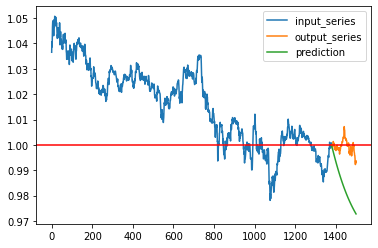

In [21]:
# train 샘플 훈련 성과 시각화해보기
# 1) 입력 series와 출력 series를 연속적으로 연결하여 시각적으로 보여주는 코드 정의
def plot_series(x_series, y_series):
    plt.plot(x_series, label = 'input_series')
    plt.plot(np.arange(len(x_series), len(x_series)+len(y_series)),
             y_series, label = 'output_series')
    plt.axhline(1, c = 'red')
    plt.legend()

# 2) train data 중 sample_id idx에 해당하는 x_series로 모델을 학습한 후 y_series를 추론
x_series = train_x_array[sample,:,1]
y_series = train_y_array[sample,:,1]
plot_series(x_series, y_series)
plt.plot(np.arange(1380, 1380+120), train_pred_array[0,:,0], label = 'prediction')
plt.legend()
plt.show() # 한눈에 봐도 학습이 전혀 되지 않고 있다는 것 알 수 있음

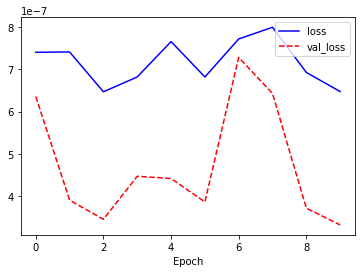

In [22]:
# 손실값 시각화
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()